# Feature Imporatnce Analysis

In [23]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configparser
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from src.utils import utils
from src.modelling import training as train



%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [24]:
proj_root = utils.get_proj_root()
config = configparser.ConfigParser(interpolation=None)
config.read(proj_root.joinpath('config/data_config.ini'))

final_year = int(config['year_limits']['end_year'])
training_data_rel_path = config['data_paths']['preprocessed_data_path']

training_data_path =  proj_root.joinpath(training_data_rel_path)
# training_data_subset_path  = proj_root.joinpath(config['data_paths']['training_subset_path'])
# testing_data_subset_path  = proj_root.joinpath(config['data_paths']['testing_subset_path'])

In [27]:
# get data
training_data = train.get_training_data(file_path=training_data_path)

from src.modelling import transforms
from sklearn.pipeline import Pipeline

categorical_features = ['industry', 'symbol']
collinear_thresh = 0.98
label_col_name = 'dps_change_next_year'

pipeline = Pipeline(steps=[
    ('cat_to_ordinal_cols', transforms.ColumnsOrdinalEncoder(col_names=categorical_features)),
    ('remove collinear columns', transforms.CollinearColsRemover(thresh=collinear_thresh, 
                                                                    label_col=label_col_name)),
])


training_data = pipeline.fit_transform(training_data)

# split dataset
train_data, test_data = train.train_test_split(df=training_data, final_year=final_year)
print(training_data.shape, train_data.shape, test_data.shape)
training_data.head()

(4620, 92) (4144, 92) (476, 92)


,year,industry,symbol,calendarYear,currentRatio,currentRatio_percentage_change,quickRatio,quickRatio_percentage_change,daysOfSalesOutstanding,daysOfSalesOutstanding_percentage_change,...,priceEarningsToGrowthRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,interestRate,interestRate_percentage_change,adjDividend,dps_growth,dps_change_next_year
0,2013,23.0,292.0,2012,2.198387,-2.275946,1.385806,-0.090461,49.567449,3.987852,...,6.939145,0.025377,-5.500411,8.692139,5.900833,0.11,-21.428571,2.54,7.627119,0
1,2014,23.0,292.0,2013,1.698186,-22.753086,1.012270,-26.954450,50.284895,1.447414,...,21.913077,0.018089,-28.717392,12.326051,41.806877,0.09,-18.181818,3.42,34.645669,0
2,2015,23.0,292.0,2014,1.961487,15.504836,1.127209,11.354593,48.611609,-3.327613,...,-39.851336,0.020773,14.836058,13.065263,5.997151,0.13,44.444444,4.10,19.883041,0
3,2016,23.0,292.0,2015,1.543411,-21.314241,0.852768,-24.346986,50.082909,3.026645,...,799.567847,0.027175,30.819267,12.318266,-5.717433,0.40,207.692308,4.44,8.292683,0
4,2017,23.0,292.0,2016,1.885512,22.165260,1.136839,33.311664,53.242552,6.308824,...,-84.149916,0.024801,-8.738086,13.479738,9.428861,1.00,150.000000,4.70,5.855856,0


In [28]:
test_data.head()

,year,industry,symbol,calendarYear,currentRatio,currentRatio_percentage_change,quickRatio,quickRatio_percentage_change,daysOfSalesOutstanding,daysOfSalesOutstanding_percentage_change,...,priceEarningsToGrowthRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,interestRate,interestRate_percentage_change,adjDividend,dps_growth,dps_change_next_year
9,2022,23.0,292.0,2021,1.704815,-9.559027,1.043165,-14.902195,48.109178,-9.839675,...,67.702091,0.033253,-0.909598,15.729376,-12.979421,1.68,2000.0,5.96,0.675676,0
19,2022,96.0,35.0,2021,1.566500,-14.191051,1.131391,-21.328131,65.431631,-11.277742,...,-112.480300,0.012391,-30.862468,19.078414,21.967224,1.68,2000.0,1.14,7.547170,0
29,2022,63.0,4.0,2021,1.849599,7.740228,1.277070,12.122625,54.968195,-18.741994,...,-69.722616,0.012897,-2.300018,23.954222,-12.035499,1.68,2000.0,1.88,4.444444,0
38,2022,30.0,3.0,2021,0.793544,-5.912486,0.562795,-6.766883,64.800701,-7.822868,...,-119.018156,0.038643,-10.545641,11.593723,-68.566197,1.68,2000.0,5.64,8.461538,0
48,2022,49.0,6.0,2022,1.233251,-1.492554,1.122526,-1.491940,69.787667,-0.681256,...,-28.558904,0.013463,28.618827,15.572515,-27.626364,1.68,2000.0,4.03,11.634349,0


In [26]:

# train_data =  pd.read_csv(training_data_subset_path)
# test_data = pd.read_csv(testing_data_subset_path)
train_data.head()
print(train_data.shape, test_data.shape)

(4144, 92) (476, 92)


In [30]:
label_col_name = 'dps_change_next_year'
X_train, y_train = train.split_Xy(train_data, label_col_name=label_col_name)
X_test, y_test = train.split_Xy(test_data, label_col_name=label_col_name)

# Feature Importance

## check feature importance

In [31]:


randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree



randomForestModel.fit(X_train, y_train)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    # print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table_sorted =  importance_table.sort_values('Importance', ascending=False).reset_index(drop=True)




/tmp/ipykernel_26791/31530044.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importance_table = pd.concat([importance_table, rowAdded])


In [32]:

importance_table_sorted =  importance_table.sort_values('Importance', ascending=False).reset_index(drop=True)
importance_table_sorted

,Feature,Importance
0,dps_growth,0.121466
1,adjDividend,0.061291
2,dividendYield,0.052707
3,priceToSalesRatio_percentage_change,0.022708
4,symbol,0.021700
...,...,...
86,operatingCashFlowSalesRatio,0.003788
87,operatingCashFlowPerShare,0.003780
88,netProfitMargin_percentage_change,0.003222
89,calendarYear,0.002172


In [33]:

feature_importance_path = proj_root.joinpath(config['modelling_paths']['feature_importance'])
importance_table_sorted.to_csv(feature_importance_path, index=False)

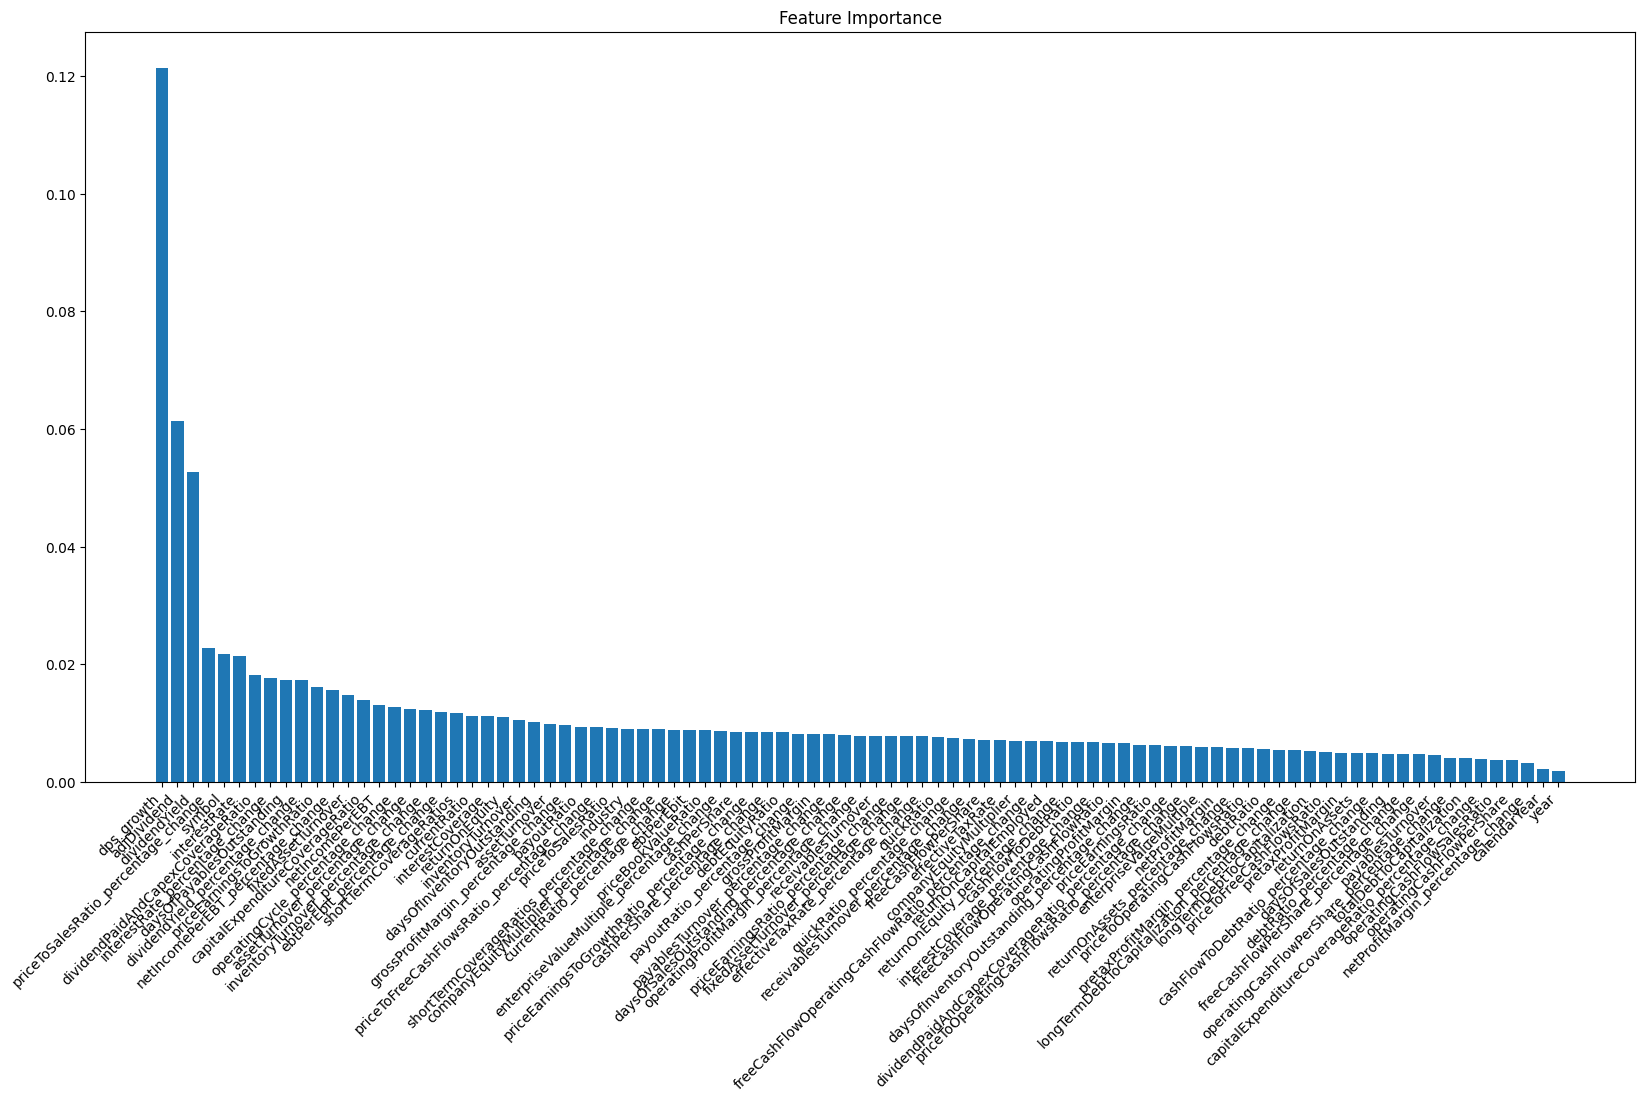

In [34]:
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
# sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.bar(importance_table_sorted['Feature'], importance_table_sorted['Importance'])
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right')
plt.show()

## Check model performance with feature importance

In [35]:
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'ROC_Score'])

# First, evaluate performance using all features
randomForestModel = RandomForestClassifier(max_features=None)
randomForestModel.fit(X_train_temp, y_train)
# Predict probabilities on test data
y_pred_probs = randomForestModel.predict_proba(X_test_temp)[:, 1]
# Compute ROC score
roc_score = roc_auc_score(y_test, y_pred_probs)
# Append the initial result to the result dataframe
new_row = pd.DataFrame({'Features_Removed': ['None'], 'ROC_Score': [roc_score]})
result_df = pd.concat([result_df, new_row])
# result_df = result_df.append({'Features_Removed': 'None', 'ROC_Score': roc_score}, ignore_index=True)
print(f"Feature_Removed: None, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")

# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted_asc = importance_table.sort_values('Importance', ascending=True)

# Loop through features, starting from the least important
for index, row in importance_table_sorted_asc.iterrows():
    # Drop the feature from training and test data
    X_train_temp = X_train_temp.drop(columns=[row['Feature']])
    X_test_temp = X_test_temp.drop(columns=[row['Feature']])
    # Train a random forest model
    randomForestModel = RandomForestClassifier(max_features=None)
    randomForestModel.fit(X_train_temp, y_train)
    # Predict probabilities on test data
    y_pred_probs = randomForestModel.predict_proba(X_test_temp)[:, 1]
    # Compute ROC score
    roc_score = roc_auc_score(y_test, y_pred_probs)
    # Append the result to the result dataframe
    new_row = pd.DataFrame({'Features_Removed': [row['Feature']], 'ROC_Score': [roc_score]})
    result_df = pd.concat([result_df, new_row])
    # result_df = result_df.append({'Features_Removed': row['Feature'], 'ROC_Score': roc_score}, ignore_index=True)
    print(
        f"Feature_Removed: {row['Feature']}, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")
    # If only one feature left, break the loop
    if X_train_temp.shape[1] == 1:
        break

/tmp/ipykernel_26791/2520037336.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, new_row])


Feature_Removed: None, Number of features used: 91, ROC_AUC_Score: 0.7485042735042735
Feature_Removed: year, Number of features used: 90, ROC_AUC_Score: 0.7977350427350427
Feature_Removed: calendarYear, Number of features used: 89, ROC_AUC_Score: 0.7721367521367521
Feature_Removed: netProfitMargin_percentage_change, Number of features used: 88, ROC_AUC_Score: 0.7611111111111111
Feature_Removed: operatingCashFlowPerShare, Number of features used: 87, ROC_AUC_Score: 0.7634188034188034
Feature_Removed: operatingCashFlowSalesRatio, Number of features used: 86, ROC_AUC_Score: 0.779017094017094
Feature_Removed: capitalExpenditureCoverageRatio_percentage_change, Number of features used: 85, ROC_AUC_Score: 0.7667094017094016
Feature_Removed: totalDebtToCapitalization, Number of features used: 84, ROC_AUC_Score: 0.7646153846153846
Feature_Removed: operatingCashFlowPerShare_percentage_change, Number of features used: 83, ROC_AUC_Score: 0.7573504273504272
Feature_Removed: payablesTurnover, Number

In [36]:
result_df.reset_index(inplace=True, drop=True)
model_performance_with_feature_drop_path = proj_root.joinpath(config['modelling_paths']['model_performance_with_feature_drop'])
result_df.to_csv(model_performance_with_feature_drop_path, index=False)

In [37]:
# result_df[result_df.index==result_df['ROC_Score'].argmax()]['Features_Removed'].values[0]

feature_removed_before_max_score = result_df.iloc[result_df['ROC_Score'].argmax(), :]['Features_Removed']

feature_rank_thresh = importance_table_sorted.index[importance_table_sorted['Feature'] == feature_removed_before_max_score][0]

max_score_features = list(importance_table_sorted[importance_table_sorted.index < feature_rank_thresh]['Feature'].values)

max_score_features



utils.save_value(value=max_score_features, fname=proj_root.joinpath(config['modelling_paths']['optimal_features']))

In [38]:
utils.load_value(fname=proj_root.joinpath(config['modelling_paths']['optimal_features']))

['dps_growth',
 'adjDividend',
 'dividendYield',
 'priceToSalesRatio_percentage_change',
 'symbol',
 'interestRate',
 'dividendPaidAndCapexCoverageRatio',
 'interestRate_percentage_change',
 'daysOfPayablesOutstanding',
 'dividendYield_percentage_change',
 'priceEarningsToGrowthRatio']

In [39]:
utils.load_value(fname=proj_root.joinpath(config['modelling_paths']['optimal_features']))

['dps_growth',
 'adjDividend',
 'dividendYield',
 'priceToSalesRatio_percentage_change',
 'symbol',
 'interestRate',
 'dividendPaidAndCapexCoverageRatio',
 'interestRate_percentage_change',
 'daysOfPayablesOutstanding',
 'dividendYield_percentage_change',
 'priceEarningsToGrowthRatio']

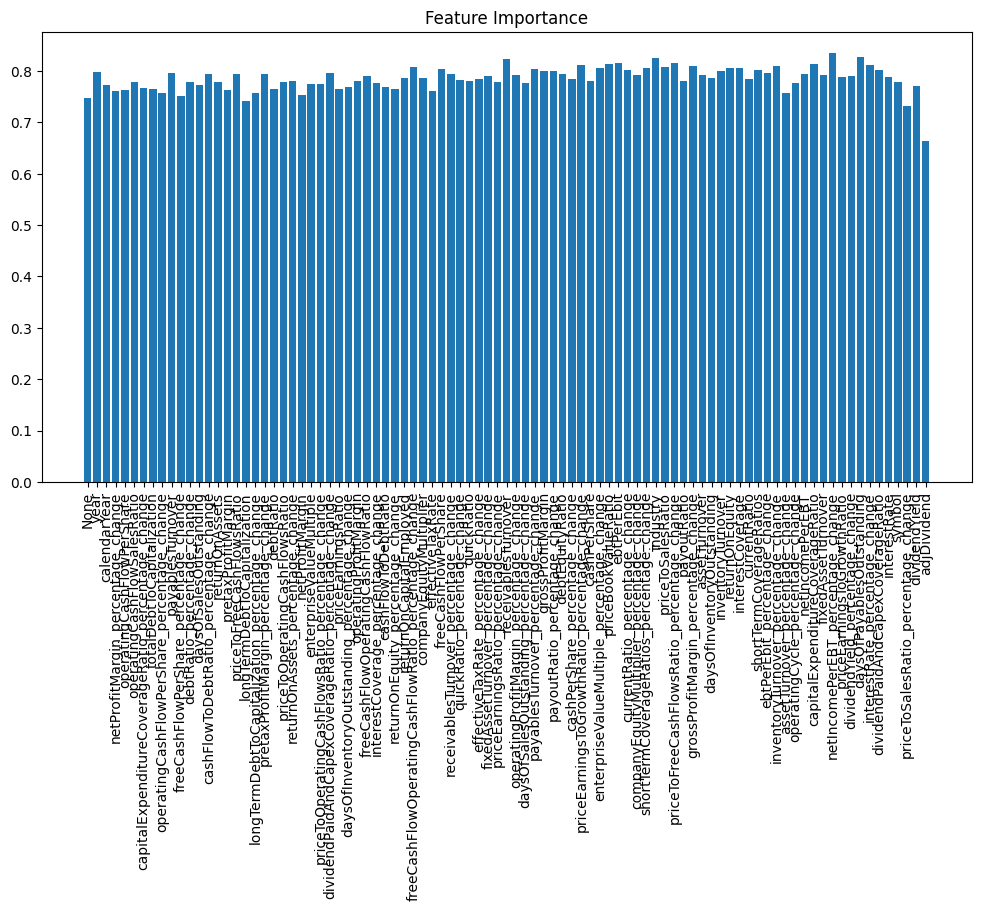

In [40]:
result_df

fig, ax = plt.subplots(figsize=(12, 6))
# plt.close()

ax.bar(result_df['Features_Removed'], result_df['ROC_Score'])

plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=90,  )
plt.show()